#### **Import Libraries**

In [1]:
# Standard library imports
import os

# Deep learning libraries
import torch
from torch.utils.data import DataLoader
import transformers
from transformers import AutoModelForSequenceClassification, AutoTokenizer, DataCollatorWithPadding

# Text processing libraries
import tiktoken
import csv
import pandas as pd

# Utility libraries
import numpy as np
import random
import math
from tqdm import tqdm
from itertools import chain
from IPython.display import display, Markdown
import textwrap

# Custom libraries  
from llmft.train import EncoderTrainer, EarlyStopping
from llmft.metrics import compute_recall, compute_f1_score
from llmft.losses import FocalLoss
from llmft.utils import predict

# Visualization libraries
import seaborn as sns  # Assuming seaborn is installed

# NLP utility (assuming trics is a library/module)
from trics.nlp.utils import to_markdown

# Configure GPU usage and tokenizer parallelism
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

# Dataset libraries (can be grouped together)
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict, concatenate_datasets, load_dataset
import torch.nn.utils as utils

#### **Parameters**

In [2]:
seed = 1                        # Seed
prompt = False 
sample_size = 3_000              # Sample Size
val_set_fraction = 0.25         # Fraction of sample used for validation set
lr = 2e-5                       # Optimizer learning rate
warmup_ratio = 0.25             # Fraction of training epochs used for learning rate warm up
batch_size = 64                 # Number of observations in each mini-batch
epochs = 50                     # Number of training epochs
patience = 15                    
gamma = 0.0
version = 8
noise = False 

#### **Path**

In [3]:
data_csv = f'./../../../toy-data/exp2/data_{version}.csv'

#### **Set Up Plotting**

In [4]:
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import rcParams
rcParams['image.interpolation'] = 'nearest'
rcParams['image.cmap'] = 'viridis'
rcParams['axes.grid'] = False
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use('seaborn-v0_8-dark-palette')

from matplotlib import font_manager 
locations = './../../../styles/Newsreader'
font_files = font_manager.findSystemFonts(fontpaths=locations)
print(locations)
print(font_files[0])
for f in font_files: 
    font_manager.fontManager.addfont(f)
plt.rcParams["font.family"] = "Newsreader"

./../../../styles/Newsreader
/home/ubuntu/llmft/styles/Newsreader/static/Newsreader_9pt/Newsreader_9pt-ExtraBoldItalic.ttf


#### **First Stage Function**

In [5]:
def fstage(var0, var1, var2, var3, var4):
    return 0.24*(var3 < 6)

#### **Format Data**

In [6]:
import re 

def remove_newlines(text):
    return re.sub(r'\n+', '', text)

string_b = 'Based on the following information, predict (Yes/No) whether the tenant will be represented in court by a lawyer.\n\n'
string1 = "Note: Some tenants have access to a free lawyer others don't. This tenant **has access** to a free lawyer.\n\n"
string0 = "Note: Some tenants have access to a free lawyer others don't. This tenant **does not have access** to a free lawyer.\n\n"
if prompt:

    context = "Also Note: Access to a lawyer does not mean the tenant will be represented in court by a lawyer." \
        " If the tenant is given access to a lawyer, they must apply for representation." \
        " Because more tenants apply than can be represented, legal aid providers prioritize tenants with **vouchers** and **disabilities** when reviewing applications." \
        " Providers can differ over what they consider to be a dissability."\
        " If a tenant's application is selected, they must follow-up with the provider to arange for legal representation." \
        " Therefore it's possible that tenants with characteristics which sugges they they should be prioritized remain without representation."
else:
    context = ''

# Read in Data Set
df = pd.read_csv(data_csv)
df['Description'] = df['Description'].apply(lambda x: remove_newlines(x))


# Subsample Observations
indices = np.random.choice(df.index, size=sample_size, replace=False)
df = df.loc[indices].reset_index(drop=True)

# Apply First Stage Function
df['FStage_Value'] = df.apply(lambda row: fstage(row['Var0'],
                                                 row['Var1'], 
                                                 row['Var2'], 
                                                 row['Var3'], 
                                                 row['Var4']), axis=1)

# If Noise: Shuffle the first stage values
if noise: 
    df['FStage_Value'] = df['FStage_Value'].sample(frac=1).reset_index(drop=True)

# Sample Instrumental Values  
df['Instrument'] = np.random.binomial(n=1, p=0.5, size=sample_size)

# Text + Instrument
df['FullDescription'] = np.where(df['Instrument'] == 1,
                             string_b + string1 + 'Description:' + df['Description'].replace("\n", "") + '\n\n' + context,
                             string_b + string0 + 'Description:' + df['Description'].replace("\n", "") + '\n\n'+ context)

# Text + Instrument == 1
df['Treated_FullDescription'] = df.apply(lambda row: string_b + string1 + 'Description:' + row['Description'].replace("\n", "") + '\n\n' + context, axis=1)

# Text + Instrument == 0
df['Control_FullDescription'] = df.apply(lambda row: string_b + string0 + 'Description:' + row['Description'].replace("\n", "") + '\n\n' + context, axis=1)

# Sample Treatment Values
df['Treatment'] = np.random.binomial(n=1, p= df['FStage_Value'] * df['Instrument'], size=sample_size)

# Sample Outcome Values
df['Outcome'] =  (1. +  2.*(df['FStage_Value'] > 0.))*df['Treatment'] + np.random.normal(size=sample_size)

print(df['FStage_Value'].mean())

0.1188


#### **Plot**

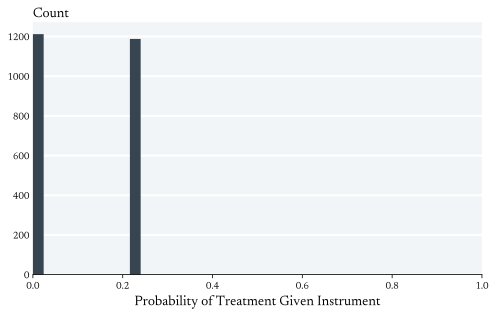

In [7]:
fig = plt.figure(dpi=300, tight_layout=True, figsize=(7, 4.5))
ax = plt.axes(facecolor=(.95, .96, .97))

# Plot customizations
for key in 'left', 'right', 'top':
    ax.spines[key].set_visible(False)
ax.text(0., 1.02, s='Count', transform=ax.transAxes, size=14)
ax.yaxis.set_tick_params(length=0)
ax.yaxis.grid(True, color='white', linewidth=2)
ax.set_axisbelow(True)
plt.hist(df['FStage_Value'], color='#36454F')
plt.xlim(0, 1)
plt.xlabel('Probability of Treatment Given Instrument', size=14)
plt.show()

#### **Set Up Device**

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cuda


#### **Tokenizer**

In [9]:
model_id = "roberta-base"#"distilbert/distilbert-base-uncased"#
tokenizer = AutoTokenizer.from_pretrained(model_id)
tokenizer.model_max_length = 512
print(tokenizer.model_max_length)

def tokenizer_function(example):
  return tokenizer(example["FullDescription"], truncation=True)

512


#### **Preprocess Data**

In [10]:
# Rename Treatment Variable to Lable because we're predicting the treatment
df = df.rename(columns={'Treatment': 'label'})

# Created Treated DataFrame
df_treated = df.copy()
df_treated.pop('FullDescription')

# Create Control DataFrame
df_control = df.copy()
df_control.pop('FullDescription')

# Rename Columns
df_treated = df_treated.rename(columns={'Treated_FullDescription': 'FullDescription'})
df_control = df_control.rename(columns={'Control_FullDescription': 'FullDescription'})

# Convert DataFrames to Datasets
original_dataset = Dataset.from_dict(df[['FullDescription','label']])
treated_dataset = Dataset.from_dict(df_treated[['FullDescription','label']])
control_dataset = Dataset.from_dict(df_control[['FullDescription','label']])

# Tokenize Datasets
tokenized_dataset = original_dataset.map(tokenizer_function, batched=True)
tokenized_treated_dataset = treated_dataset.map(tokenizer_function, batched=True)
tokenized_control_dataset = control_dataset.map(tokenizer_function, batched=True)

# Remove Column
tokenized_dataset = tokenized_dataset.remove_columns(['FullDescription'])
tokenized_treated_dataset = tokenized_treated_dataset.remove_columns(['FullDescription'])
tokenized_control_dataset = tokenized_control_dataset.remove_columns(['FullDescription'])

# Split Dataset
tokenized_dataset_split = tokenized_dataset.train_test_split(test_size=val_set_fraction, seed=42)
train_set = tokenized_dataset_split['train'].add_column('val_indicator', [0] * len(tokenized_dataset_split['train']))
val_set = tokenized_dataset_split['test'].add_column('val_indicator', [1] * len(tokenized_dataset_split['test']))

# Combining back into a single dataset for unified handling
combined_dataset = concatenate_datasets([train_set, val_set])

Map:   0%|          | 0/2400 [00:00<?, ? examples/s]

Map:   0%|          | 0/2400 [00:00<?, ? examples/s]

Map:   0%|          | 0/2400 [00:00<?, ? examples/s]

Flattening the indices:   0%|          | 0/1800 [00:00<?, ? examples/s]

Flattening the indices:   0%|          | 0/600 [00:00<?, ? examples/s]

#### **DataLoaders**

In [11]:
treated_loader = DataLoader(tokenized_treated_dataset, batch_size=batch_size, collate_fn=DataCollatorWithPadding(tokenizer), shuffle=False)
control_loader = DataLoader(tokenized_control_dataset, batch_size=batch_size, collate_fn=DataCollatorWithPadding(tokenizer), shuffle=False)
all_loader = DataLoader(tokenized_dataset, batch_size=batch_size, collate_fn=DataCollatorWithPadding(tokenizer), shuffle=False)
loader_with_val_idx = DataLoader(combined_dataset, batch_size=batch_size, collate_fn=DataCollatorWithPadding(tokenizer), shuffle=False)
train_loader = DataLoader(tokenized_dataset_split['train'], batch_size=batch_size, collate_fn=DataCollatorWithPadding(tokenizer), shuffle=True)
val_loader = DataLoader(tokenized_dataset_split['test'], batch_size=batch_size, collate_fn=DataCollatorWithPadding(tokenizer))

#### **Model**

In [12]:
model = AutoModelForSequenceClassification.from_pretrained(model_id,
                                                           num_labels=2)
model = model.to(device)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### **Optimizer and Scheduler**

In [13]:
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = transformers.optimization.get_linear_schedule_with_warmup(optimizer,int(warmup_ratio*len(train_loader)*epochs), len(train_loader)*epochs)

#### **Trainer**

In [14]:
criterion = torch.nn.CrossEntropyLoss()
metric_fn =  lambda a, b: (compute_f1_score(a,b), compute_recall(a,b))
yuri = EncoderTrainer(model, optimizer, scheduler, criterion, device, metric_fn)
early_stopping = EarlyStopping(patience)

#### **Train**

Epoch: 1, Train Loss: 0.7526, Val Loss: 0.7125:   0%|          | 0/50 [00:15<?, ?it/s]

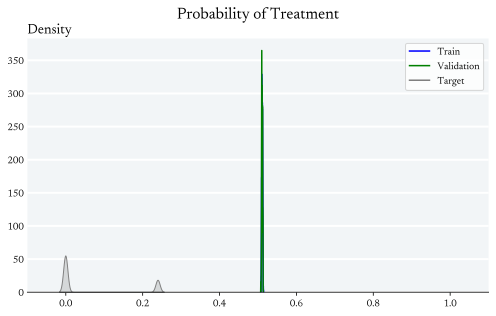

Epoch: 2, Train Loss: 0.5652, Val Loss: 0.2518:   2%|▏         | 1/50 [00:38<18:39, 22.85s/it]

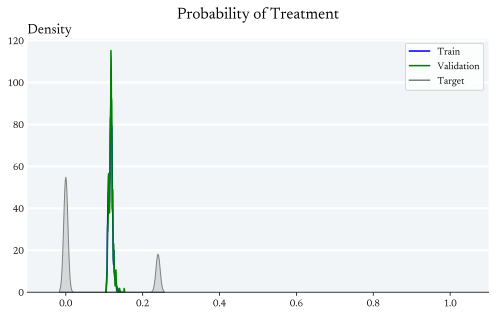

Epoch: 3, Train Loss: 0.2547, Val Loss: 0.2415:   4%|▍         | 2/50 [01:00<18:11, 22.73s/it]

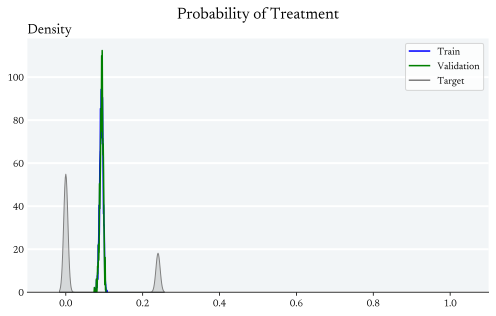

Epoch: 4, Train Loss: 0.2427, Val Loss: 0.2260:   6%|▌         | 3/50 [01:23<17:46, 22.69s/it]

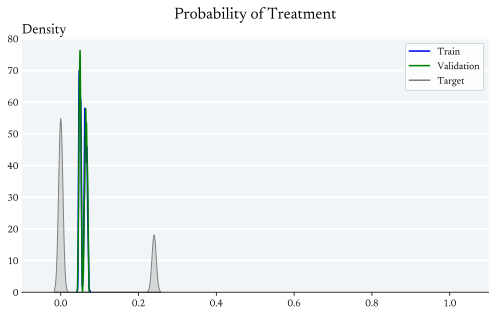

Epoch: 5, Train Loss: 0.2290, Val Loss: 0.1888:   8%|▊         | 4/50 [01:45<17:22, 22.67s/it]

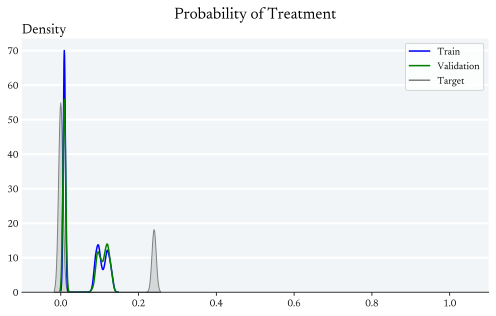

Epoch: 6, Train Loss: 0.1759, Val Loss: 0.1571:  10%|█         | 5/50 [02:08<16:57, 22.60s/it]

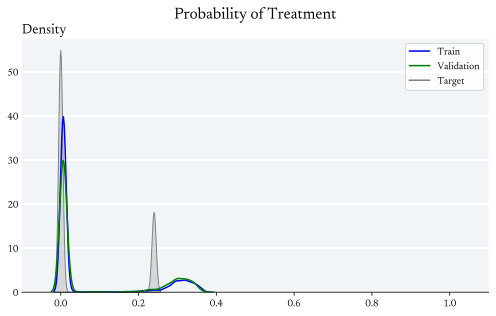

Epoch: 7, Train Loss: 0.1470, Val Loss: 0.1748:  12%|█▏        | 6/50 [02:31<16:34, 22.61s/it]

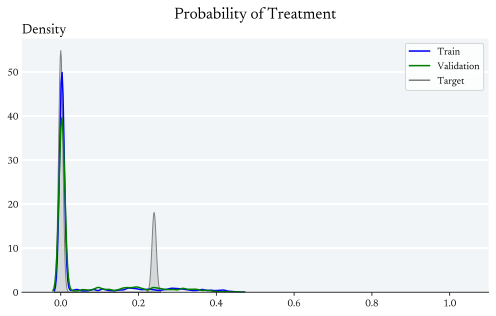

Epoch: 8, Train Loss: 0.1517, Val Loss: 0.1666:  14%|█▍        | 7/50 [02:52<15:58, 22.30s/it]

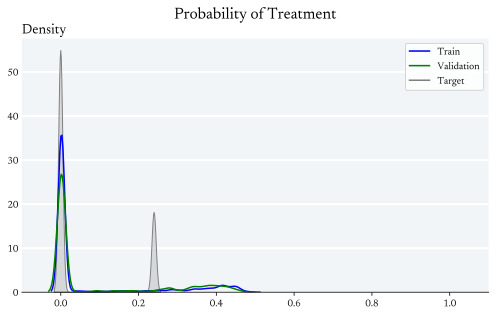

Epoch: 9, Train Loss: 0.1616, Val Loss: 0.2082:  16%|█▌        | 8/50 [03:14<15:27, 22.08s/it]

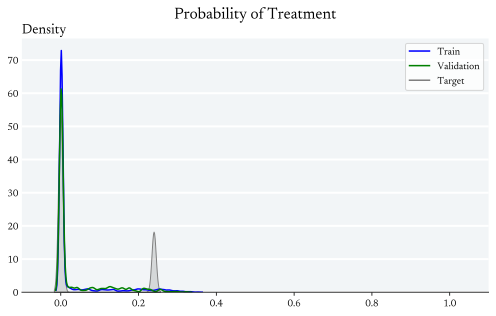

Epoch: 10, Train Loss: 0.1410, Val Loss: 0.2728:  18%|█▊        | 9/50 [03:36<15:00, 21.96s/it]

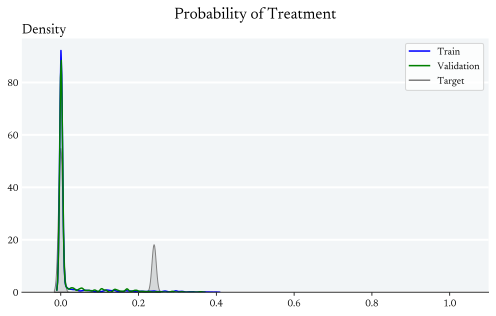

Epoch: 11, Train Loss: 0.1363, Val Loss: 0.2019:  20%|██        | 10/50 [03:57<14:34, 21.85s/it]

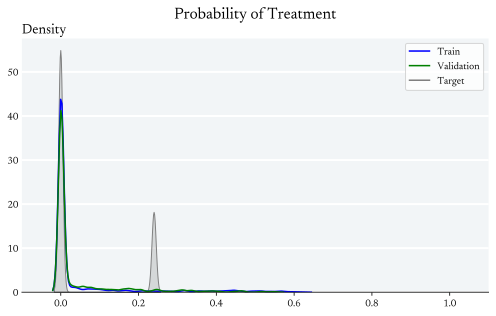

Epoch: 12, Train Loss: 0.1272, Val Loss: 0.1897:  22%|██▏       | 11/50 [04:19<14:08, 21.76s/it]

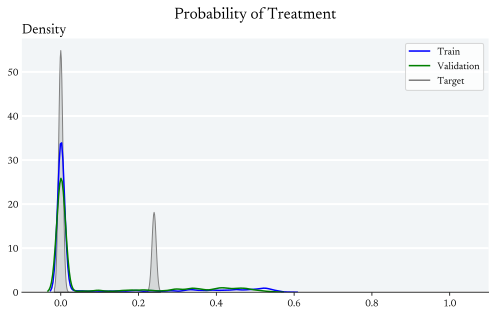

Epoch: 13, Train Loss: 0.1070, Val Loss: 0.2071:  24%|██▍       | 12/50 [04:40<13:44, 21.71s/it]

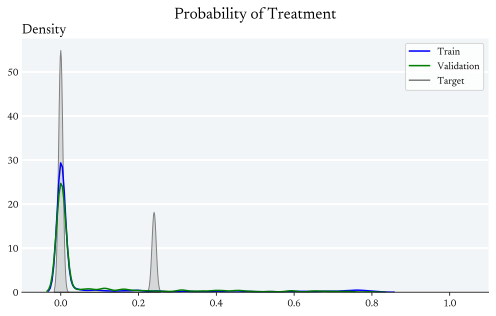

Epoch: 14, Train Loss: 0.0947, Val Loss: 0.3090:  26%|██▌       | 13/50 [05:02<13:20, 21.63s/it]

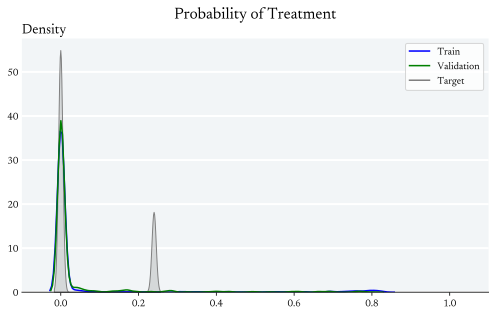

Epoch: 15, Train Loss: 0.0599, Val Loss: 0.3290:  28%|██▊       | 14/50 [05:23<12:58, 21.63s/it]

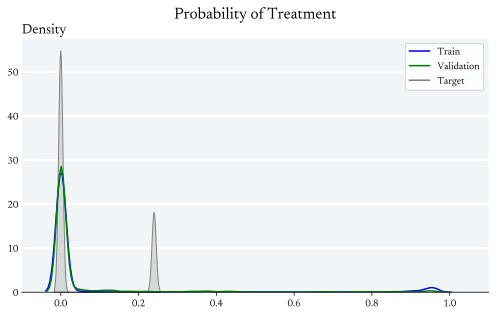

Epoch: 16, Train Loss: 0.0554, Val Loss: 0.3611:  30%|███       | 15/50 [05:45<12:36, 21.60s/it]

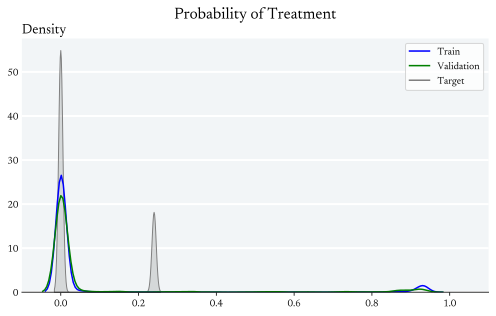

Epoch: 17, Train Loss: 0.0637, Val Loss: 0.4290:  32%|███▏      | 16/50 [06:06<12:13, 21.58s/it]

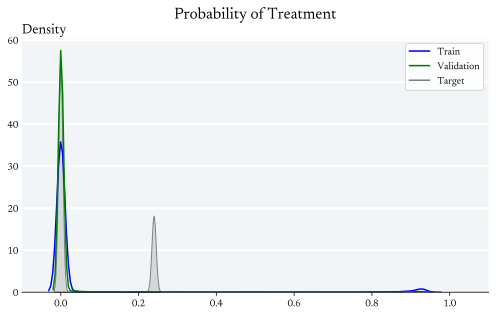

Epoch: 18, Train Loss: 0.0513, Val Loss: 0.4364:  34%|███▍      | 17/50 [06:28<11:53, 21.62s/it]

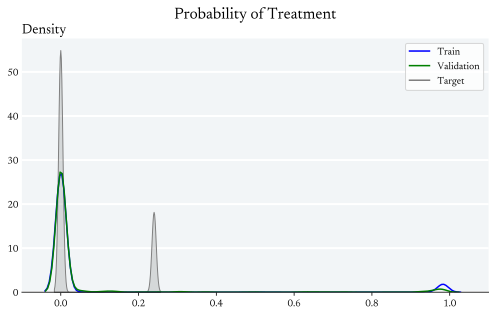

Epoch: 19, Train Loss: 0.0309, Val Loss: 0.4849:  36%|███▌      | 18/50 [06:50<11:31, 21.61s/it]

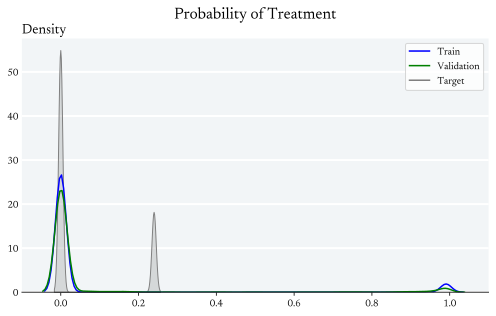

Epoch: 20, Train Loss: 0.0243, Val Loss: 0.5169:  38%|███▊      | 19/50 [07:11<11:10, 21.63s/it]

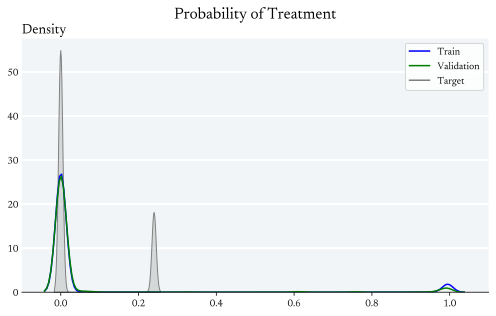

Epoch: 21, Train Loss: 0.0225, Val Loss: 0.5746:  40%|████      | 20/50 [07:33<11:20, 22.67s/it]


***Early stopping***
Min Validation Loss: 5
Current Epoch: 20


<All keys matched successfully>

In [15]:
# Compute Initial Train/Validation Losses
evaluation_losses = [yuri.evaluate(val_loader)[0]]
training_losses =  [yuri.evaluate(train_loader)[0]]
pbar =  tqdm(range(epochs), desc=f'Epoch: 0, Train Loss: {training_losses[0]:.3f}, Val Loss: {evaluation_losses[0]:.3f}')

# Initialize Empty Lists to Store Recall and Learning Rate Histories
metric_history = []
learning_rate_history = []

for epoch in pbar:

    train_loss, _, _, metrics, current_lr = yuri.train(train_loader)

    training_losses.append(train_loss)
    metric_history.append(metrics)
    learning_rate_history.append(current_lr)
    
    val_loss = yuri.evaluate(val_loader)[0]
    evaluation_losses.append(val_loss)

    # Update the progress bar description for the current epoch
    pbar.set_description(f'Epoch: {epoch + 1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

    
    # Call early stopping
    early_stopping(val_loss, model, epoch)
    if early_stopping.early_stop:
        print("***Early stopping***")
        print(f"Min Validation Loss: {early_stopping.best_epoch}")
        print(f"Current Epoch: {epoch}")
        break

    # Create figure and axes with specific settings
    Dhat, labels, val_indicator = predict(model, loader_with_val_idx, device)
    fig = plt.figure(dpi=300, tight_layout=True, figsize=(7, 4.5))
    ax = plt.axes(facecolor=(.95, .96, .97))
    ax.set_title('Probability of Treatment', size=16, pad=20)

    # Set visibility of some spines
    for key in 'left', 'right', 'top':
        ax.spines[key].set_visible(False)

    # Add text to the axes
    ax.text(0., 1.02, s='Density', transform=ax.transAxes, size=14)

    # Set Y-axis tick parameters and grid
    ax.yaxis.set_tick_params(length=0)
    ax.yaxis.grid(True, color='white', linewidth=2)
    ax.set_axisbelow(True)

    # Plot the KDE plot
    sns.kdeplot(Dhat[val_indicator==0].reshape(-1,), color='blue', fill=False, bw_adjust=0.25, label='Train')
    sns.kdeplot(Dhat[val_indicator==1].reshape(-1,), color='green', fill=False, bw_adjust=0.25, label='Validation')
    fill_kde = sns.kdeplot((df['FStage_Value']*df['Instrument']).values.reshape(-1,), fill=True, color='grey', bw_adjust=0.25, label='Target')

    # Create custom legend handles
    from matplotlib.lines import Line2D
    legend_handles = [
        Line2D([0], [0], color='blue', label='Train'),
        Line2D([0], [0], color='green', label='Validation'),
        Line2D([0], [0], color='grey', label='Target')
    ]

    # Set custom legend
    plt.legend(handles=legend_handles)
    plt.ylabel('')
    plt.xlim(-0.1,1.1)
    plt.show()

model.load_state_dict(torch.load('checkpoint.pt'))

#### **Loss History**

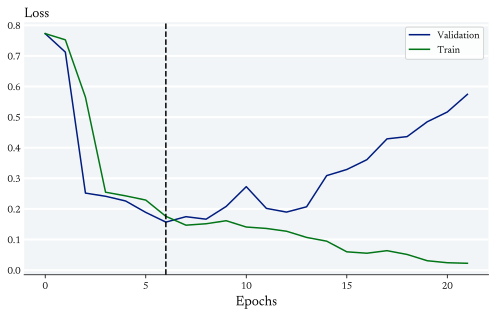

In [16]:
fig = plt.figure(dpi=300, tight_layout=True, figsize=(7, 4.5))
ax = plt.axes(facecolor=(.95, .96, .97))

# Set visibility of some spines
for key in 'left', 'right', 'top':
    ax.spines[key].set_visible(False)

# Add text to the axes
ax.text(0., 1.02, s='Loss', transform=ax.transAxes, size=14)

# Set Y-axis tick parameters and grid
ax.yaxis.set_tick_params(length=0)
ax.yaxis.grid(True, color='white', linewidth=2)
ax.set_axisbelow(True)
plt.plot(evaluation_losses, label='Validation')
plt.plot(training_losses, label='Train')
plt.axvline(early_stopping.best_epoch + 1, color='black', linestyle='--')
plt.legend()
plt.xlabel('Epochs', size=14)
plt.show()

#### **F1-Score**

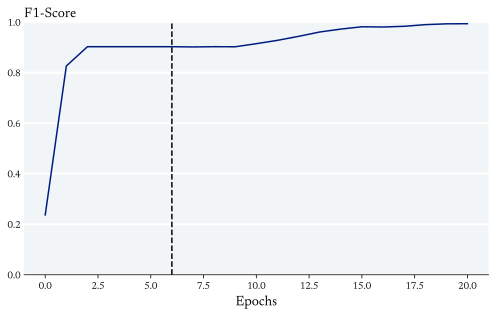

In [17]:
fig = plt.figure(dpi=300, tight_layout=True, figsize=(7, 4.5))
ax = plt.axes(facecolor=(.95, .96, .97))

# Set visibility of some spines
for key in 'left', 'right', 'top':
    ax.spines[key].set_visible(False)

# Add text to the axes
ax.text(0., 1.02, s='F1-Score', transform=ax.transAxes, size=14)

# Set Y-axis tick parameters and grid
ax.yaxis.set_tick_params(length=0)
ax.yaxis.grid(True, color='white', linewidth=2)
ax.set_axisbelow(True)
plt.plot([i[0] for i in metric_history])
plt.axvline(early_stopping.best_epoch + 1, color='black', linestyle='--')
plt.xlabel('Epochs', size=14)
plt.ylim(0, 1)
plt.show()

#### **Recall**

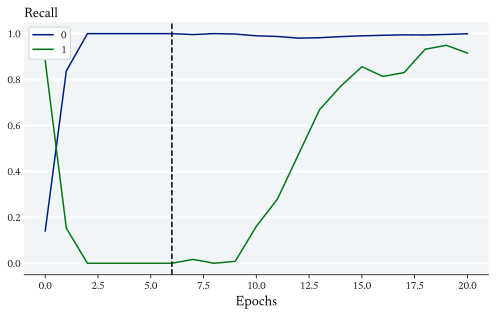

In [18]:
fig = plt.figure(dpi=300, tight_layout=True, figsize=(7, 4.5))
ax = plt.axes(facecolor=(.95, .96, .97))

# Set visibility of some spines
for key in 'left', 'right', 'top':
    ax.spines[key].set_visible(False)

# Add text to the axes
ax.text(0., 1.02, s='Recall', transform=ax.transAxes, size=14)

# Set Y-axis tick parameters and grid
ax.yaxis.set_tick_params(length=0)
ax.yaxis.grid(True, color='white', linewidth=2)
ax.set_axisbelow(True)
plt.plot([i[1][0][0] for i in metric_history], label='0')
plt.plot([i[1][0][1] for i in metric_history], label='1')
plt.axvline(early_stopping.best_epoch + 1, color='black', linestyle='--')
plt.xlabel('Epochs', size=14)
plt.legend()
plt.show()

In [19]:
Dhat, labels = predict(model, all_loader, device)
Dhat1, _  = predict(model, treated_loader, device)
Dhat0, _  = predict(model, control_loader, device)

In [20]:
import jax.numpy as jnp 

residuals = (Dhat - (0.5 *Dhat1 + 0.5*Dhat0)).reshape(-1,1)
regs = jnp.hstack((residuals, jnp.ones_like(residuals)))
est = jnp.linalg.lstsq(regs, df['Outcome'].values.reshape(-1,1))[0][0]
df_result = pd.DataFrame({'Estimate': est})
print(est)

2024-07-09 20:32:14.764419: W external/xla/xla/service/gpu/nvptx_compiler.cc:760] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.5.82). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a reco

[2.7668037]


In [21]:
est[0]

Array(2.7668037, dtype=float32)

In [22]:
est

Array([2.7668037], dtype=float32)

In [23]:
np.allclose(labels, df['label'])

True

In [24]:
# Define the path for the CSV file
file_path = f'./../../../toy-data/exp2/results/bert_{version}_{sample_size}_{noise}.csv'

# Check if the file already exists
if not os.path.exists(file_path):
    # If the file does not exist, write with headers
    df_result[['Estimate']].to_csv(file_path, mode='w', header=True, index=False)
else:
    # If the file exists, append without headers
    df_result[['Estimate']].to_csv(file_path, mode='a', header=False, index=False)